In [14]:
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to combine two dataframes (1d and 1h) into one figure with SMAs
def plot_combined_candlestick_with_sma(df1d, df1h, num_candles_1d, num_candles_1h, title1, title2, short_window=10, long_window=50):
    # Filter the data for the desired number of candles
    df1d = df1d[-num_candles_1d:]
    df1h = df1h[-num_candles_1h:]
    # df1d = df1d.loc['2024-05-01':'2024-08-12']
    # df1h = df1h.loc['2024-08-05 11:00:00':'2024-08-13 10:00:00']
    
    # Calculate short and long term moving averages for both dataframes
    df1d['SMA_Short'] = df1d['Close'].rolling(window=short_window).mean()
    df1d['SMA_Long'] = df1d['Close'].rolling(window=long_window).mean()
    
    df1h['SMA_Short'] = df1h['Close'].rolling(window=short_window).mean()
    df1h['SMA_Long'] = df1h['Close'].rolling(window=long_window).mean()
    
    # Set up the chart with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot daily candlestick with SMAs
    apds1d = [mpf.make_addplot(df1d['SMA_Short'], ax=ax1, color='blue', label=f'SMA {short_window} periods'),
              mpf.make_addplot(df1d['SMA_Long'], ax=ax1, color='orange', label=f'SMA {long_window} periods')]
    
    mpf.plot(df1d, type='candle', style='charles', ax=ax1, axtitle=title1,
             ylabel='Price', addplot=apds1d, show_nontrading=False)
    
    # Plot hourly candlestick with SMAs
    apds1h = [mpf.make_addplot(df1h['SMA_Short'], ax=ax2, color='blue', label=f'SMA {short_window} periods'),
              mpf.make_addplot(df1h['SMA_Long'], ax=ax2, color='orange', label=f'SMA {long_window} periods')]
    
    mpf.plot(df1h, type='candle', style='charles', ax=ax2, axtitle=title2,
             ylabel='Price', addplot=apds1h, show_nontrading=False)
    
    # Add the legends
    ax1.legend(fontsize=14)
    ax2.legend(fontsize=14)

    # Increase the number of ticks for the price and date labels
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the x-axis (dates)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the y-axis (prices)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the x-axis (dates)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the y-axis (prices)
    
    # Increase axis title and label font size
    ax1.set_title(title1, fontsize=20)
    ax1.set_ylabel('Price', fontsize=16)
    ax2.set_title(title2, fontsize=20)
    ax2.set_ylabel('Price', fontsize=16)
    
    # Adjust spacing between the charts
    plt.subplots_adjust(hspace=0.4)
    
    # Return the figure (do not display yet)
    return fig, (ax1, ax2)

# Function to read the CSV and return the dataframe
def read_csv_to_dataframe(file_path):
    # Read the CSV
    df = pd.read_csv(file_path)
    
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)
    
    # Ensure that the 'Open', 'High', 'Low', 'Close' columns are numeric
    df = df[['Open', 'High', 'Low', 'Close']].apply(pd.to_numeric)
    
    return df


# Function to combine two dataframes (1d and 1h) into one figure with SMAs and rolling support/resistance levels
def plot_combined_candlestick_with_sma_and_levels(df1d, df1h, num_candles_1d, num_candles_1h, title1, title2, short_window=10, long_window=50, level_window=20):
    # Filter the data for the desired number of candles
    df1d = df1d[-num_candles_1d:]
    df1h = df1h[-num_candles_1h:]
    
    # Calculate short and long term moving averages for both dataframes
    df1d['SMA_Short'] = df1d['Close'].rolling(window=short_window).mean()
    df1d['SMA_Long'] = df1d['Close'].rolling(window=long_window).mean()
    
    df1h['SMA_Short'] = df1h['Close'].rolling(window=short_window).mean()
    df1h['SMA_Long'] = df1h['Close'].rolling(window=long_window).mean()
    
    # Calculate rolling support and resistance levels
    df1d['Support'] = df1d['Low'].rolling(window=level_window).min()
    df1d['Resistance'] = df1d['High'].rolling(window=level_window).max()
    
    df1h['Support'] = df1h['Low'].rolling(window=level_window).min()
    df1h['Resistance'] = df1h['High'].rolling(window=level_window).max()
    
    # Set up the chart with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot daily candlestick with SMAs and support/resistance levels
    apds1d = [
        mpf.make_addplot(df1d['SMA_Short'], ax=ax1, color='blue', label=f'SMA {short_window} periods'),
        mpf.make_addplot(df1d['SMA_Long'], ax=ax1, color='orange', label=f'SMA {long_window} periods'),
        mpf.make_addplot(df1d['Support'], ax=ax1, color='green', linestyle='--', label=f'Support (Window={level_window})'),
        mpf.make_addplot(df1d['Resistance'], ax=ax1, color='red', linestyle='--', label=f'Resistance (Window={level_window})')
    ]
    
    mpf.plot(df1d, type='candle', style='charles', ax=ax1, axtitle=title1,
             ylabel='Price', addplot=apds1d, show_nontrading=False)
    
    # Plot hourly candlestick with SMAs and support/resistance levels
    apds1h = [
        mpf.make_addplot(df1h['SMA_Short'], ax=ax2, color='blue', label=f'SMA {short_window} periods'),
        mpf.make_addplot(df1h['SMA_Long'], ax=ax2, color='orange', label=f'SMA {long_window} periods'),
        mpf.make_addplot(df1h['Support'], ax=ax2, color='green', linestyle='--', label=f'Support (Window={level_window})'),
        mpf.make_addplot(df1h['Resistance'], ax=ax2, color='red', linestyle='--', label=f'Resistance (Window={level_window})')
    ]
    
    mpf.plot(df1h, type='candle', style='charles', ax=ax2, axtitle=title2,
             ylabel='Price', addplot=apds1h, show_nontrading=False)
    
    # Add the legends
    ax1.legend(fontsize=14)
    ax2.legend(fontsize=14)

    # Increase the number of ticks for the price and date labels
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the x-axis (dates)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the y-axis (prices)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the x-axis (dates)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))  # More ticks on the y-axis (prices)
    
    # Increase axis title and label font size
    ax1.set_title(title1, fontsize=20)
    ax1.set_ylabel('Price', fontsize=16)
    ax2.set_title(title2, fontsize=20)
    ax2.set_ylabel('Price', fontsize=16)
    
    # Adjust spacing between the charts
    plt.subplots_adjust(hspace=0.4)
    
    # Return the figure (do not display yet)
    return fig, (ax1, ax2)


def save_plot_figure(fig, filename):
    # Salvar a figura no arquivo especificado
    fig.savefig(filename, bbox_inches='tight')
    
    # Fechar a figura para liberar memória
    plt.close(fig)
    
    return filename

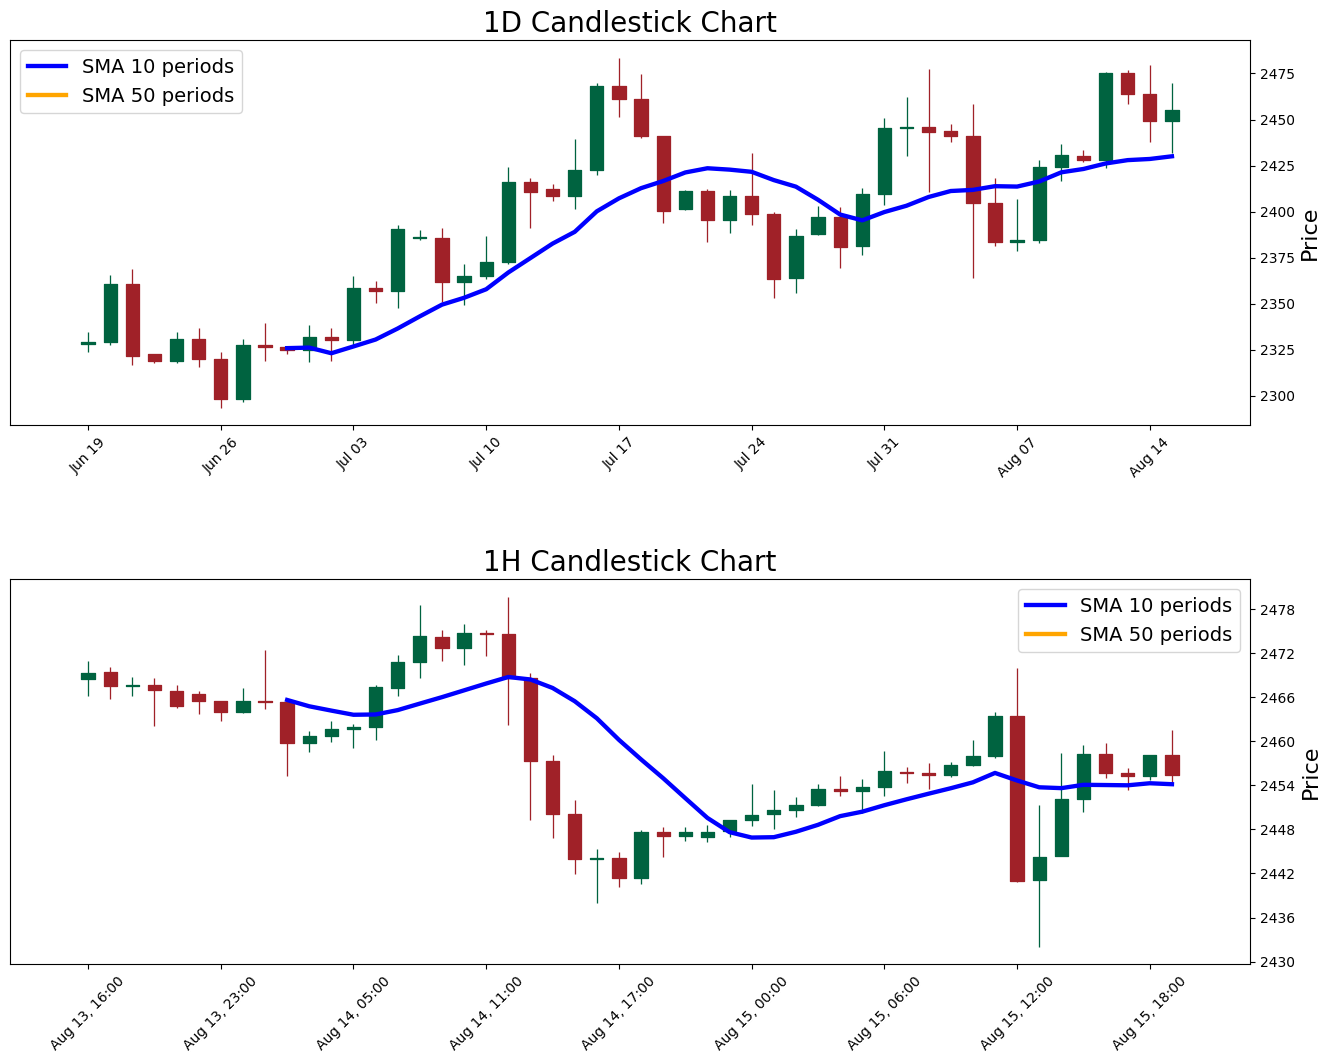

In [15]:
df1 = read_csv_to_dataframe('XAUUSD_D1.csv')
df2 = read_csv_to_dataframe('XAUUSD_H1.csv')
# Example usage
fig, (ax1, ax2) = plot_combined_candlestick_with_sma(df1, df2, 50, 50, '1D Candlestick Chart', '1H Candlestick Chart')
fig.show()  # Show the combined chart

In [16]:
df1_aux = df1.loc['2024-01-01':'2024-08-15']
df2_aux = df2.loc['2024-01-01 01:00:00':'2024-08-13 10:00:00']

In [17]:
df1_aux

,Open,High,Low,Close
Date,,,,
2024-01-01,2062.598,2066.595,2062.405,2063.615
2024-01-02,2063.625,2078.825,2055.818,2059.455
2024-01-03,2059.475,2065.835,2030.515,2042.895
2024-01-04,2042.865,2050.855,2036.155,2044.098
2024-01-05,2044.128,2063.838,2024.255,2045.355
...,...,...,...,...
2024-08-11,2430.298,2433.305,2426.835,2427.765
2024-08-12,2427.835,2475.855,2423.695,2475.425
2024-08-13,2475.445,2476.845,2458.365,2463.975


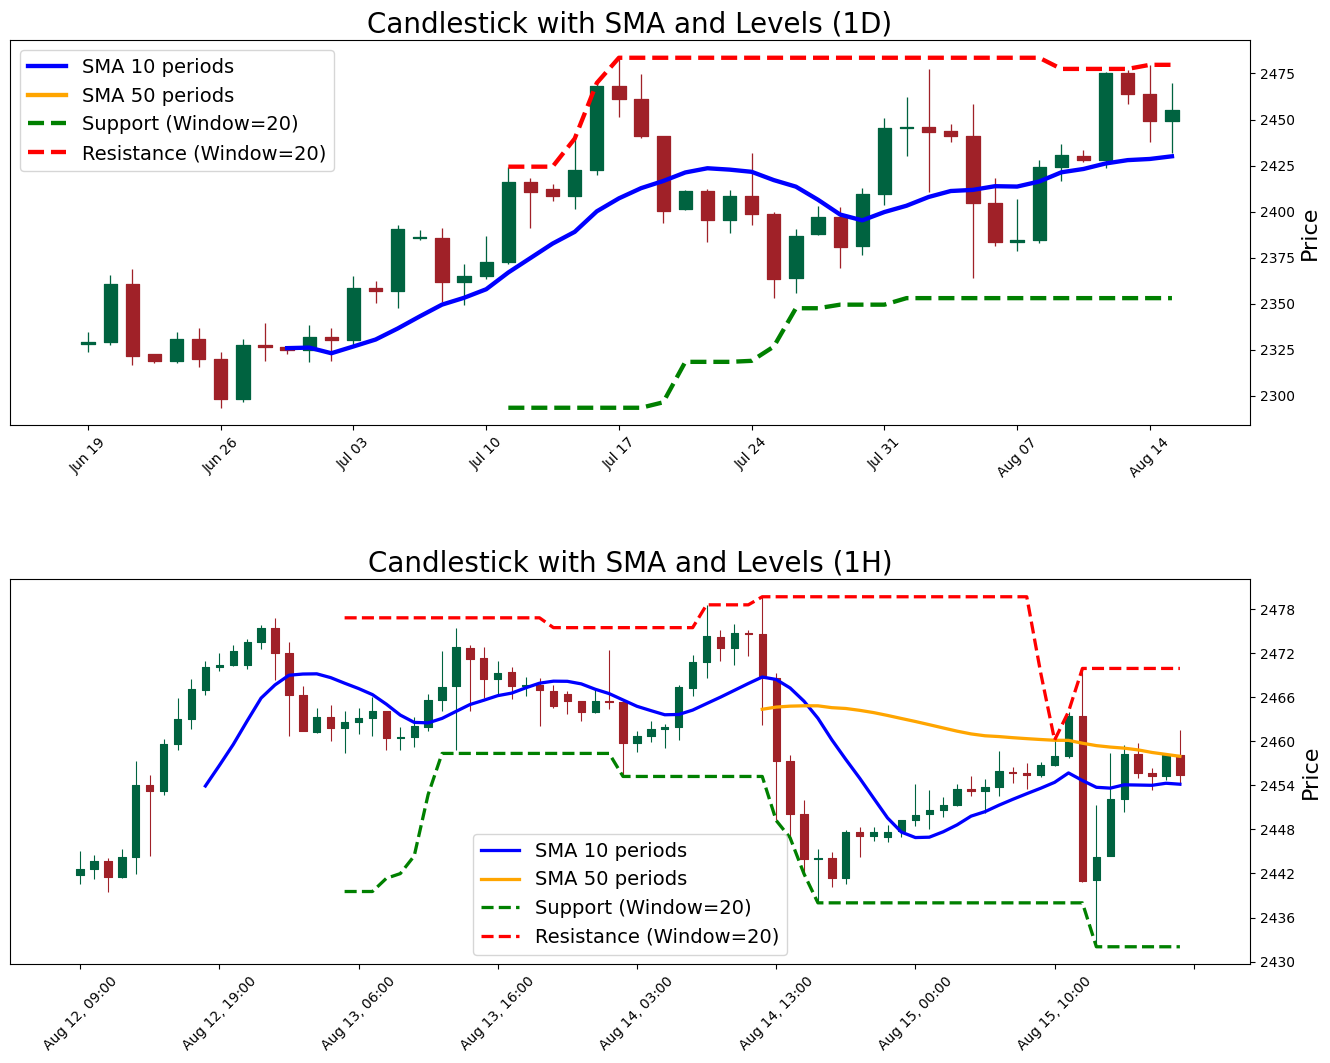

In [18]:
fig, (ax1, ax2) = plot_combined_candlestick_with_sma_and_levels(df1, df2,
                                                                num_candles_1d=50, 
                                                                num_candles_1h=80, 
                                                                title1='Candlestick with SMA and Levels (1D)', 
                                                                title2='Candlestick with SMA and Levels (1H)',
                                                                short_window=10, 
                                                                long_window=50, 
                                                                level_window=20)
fig.show()  # Display the combined chart

In [19]:
save_plot_figure(fig, 'file9.jpg')

'file9.jpg'

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import mplfinance as mpf
# import os
# from datetime import timedelta, datetime

# # Function to generate and save charts for each day and hour in 2024
# def generate_yearly_charts(df1d, df1h, output_dir, num_candles_1d=50, num_candles_1h=80, short_window=10, long_window=50, level_window=20):
#     # Ensure the output directory exists
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # Define the start and end dates for the year 2024
#     start_date = datetime(2024, 1, 1)
#     end_date = datetime(2024, 2, 1)

#     # Loop through each day of the year 2024
#     current_date = start_date
#     while current_date <= end_date:
#         # Set the start and end dates for the daily chart
#         start_date_1d = current_date - timedelta(days=num_candles_1d)
#         end_date_1d = current_date

#         # Filter the daily data based on the date range
#         df1d_filtered = df1d.loc[start_date_1d:end_date_1d]

#         # Skip if no daily data exists for this day
#         if df1d_filtered.empty:
#             current_date += timedelta(days=1)
#             continue

#         # Loop through each hour of the next day
#         for hour in range(0, 24):
#             # Set the start and end times for the hourly chart
#             start_time_1h = current_date + timedelta(days=1, hours=hour) - timedelta(hours=num_candles_1h)
#             end_time_1h = current_date + timedelta(days=1, hours=hour)

#             # Filter the hourly data based on the time range
#             df1h_filtered = df1h.loc[start_time_1h:end_time_1h]

#             # Check if data exists for this hour and skip if no data is available
#             if df1h_filtered.empty:
#                 continue  # Skip this hour if there's no data

#             # Ensure we have exactly `num_candles_1h` rows by checking and adjusting the selection
#             if len(df1h_filtered) < num_candles_1h:
#                 start_time_1h_adjusted = start_time_1h - timedelta(hours=num_candles_1h - len(df1h_filtered))
#                 df1h_filtered = df1h.loc[start_time_1h_adjusted:end_time_1h]

#             # Skip this iteration if the data is still insufficient
#             if len(df1h_filtered) < num_candles_1h:
#                 continue

#             # Generate the combined candlestick chart with SMA and support/resistance levels
#             fig, (ax1, ax2) = plot_combined_candlestick_with_sma_and_levels(
#                 df1d_filtered, df1h_filtered,
#                 num_candles_1d=num_candles_1d,
#                 num_candles_1h=num_candles_1h,
#                 title1=f'Candlestick with SMA and Levels (1D) - {end_date_1d.date()}',
#                 title2=f'Candlestick with SMA and Levels (1H) - {end_time_1h.strftime("%Y-%m-%d %H:%M")}',
#                 short_window=short_window, long_window=long_window, level_window=level_window
#             )

#             # Create a filename for saving the image
#             filename = os.path.join(output_dir, f'chart_{end_date_1d.strftime("%Y-%m-%d")}_{end_time_1h.strftime("%H-%M")}.png')

#             # Save the figure as an image
#             save_plot_figure(fig, filename)

#         # Move to the next day
#         current_date += timedelta(days=1)

# # Example usage
# # Assuming df1d (daily data) and df1h (hourly data) are already loaded using read_csv_to_dataframe()
# generate_yearly_charts(df1, df2, 'charts_2024-2', num_candles_1d=50, num_candles_1h=80)


In [21]:
df1 = read_csv_to_dataframe('XAUUSD_D1.csv')
df2 = read_csv_to_dataframe('XAUUSD_H1.csv')

In [22]:
df1_aux = df1.loc['2023-10-01':'2024-08-15']
df2_aux = df2.loc['2024-01-01 01:00:00':'2024-08-15 10:00:00']

In [23]:
df1_aux

,Open,High,Low,Close
Date,,,,
2023-10-01,1847.268,1848.645,1845.595,1848.285
2023-10-02,1848.295,1848.835,1820.405,1824.845
2023-10-03,1824.818,1833.205,1815.245,1823.255
2023-10-04,1823.225,1830.455,1816.475,1822.425
2023-10-05,1822.445,1829.105,1812.924,1821.138
...,...,...,...,...
2024-08-11,2430.298,2433.305,2426.835,2427.765
2024-08-12,2427.835,2475.855,2423.695,2475.425
2024-08-13,2475.445,2476.845,2458.365,2463.975


In [24]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import os
import gc  # For garbage collection
from datetime import timedelta

# Function to generate and save charts based on the actual data in the CSV for the year 2024
def generate_charts_from_csv(df1d, df1h, output_dir, num_candles_1d=60, num_candles_1h=80, short_window=10, long_window=40, level_window=20):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Filter the hourly and daily data to only include data from the year 2024
    df1d = df1d[df1d.index.year >= 2023]
    df1h = df1h[df1h.index.year == 2024]

    # Sort the hourly data by date to ensure we iterate in the correct order
    df1h = df1h.sort_index()
    df1d = df1d.sort_index()

    # Make sure we have at least 80 hourly candles before generating charts
    if len(df1h) < num_candles_1h or len(df1d) < num_candles_1d:
        print("Not enough data to start generating charts.")
        return

    # Iterate over each timestamp in the hourly data, starting from index 80
    for idx, current_time in enumerate(df1h.index[num_candles_1h:], start=num_candles_1h):
        # Get the corresponding daily date, adjusted for weekends
        daily_time = current_time - timedelta(days=1)

        # If the current_time is a Monday, adjust to get the last Friday
        if daily_time.weekday() == 6:  # Sunday
            daily_time = current_time - timedelta(days=2)  # Go back to Friday
        elif daily_time.weekday() == 5:  # Saturday
            daily_time = current_time - timedelta(days=1)  # Go back to Friday

        # Now, ensure df1d_filtered ends on the day before current_time (adjusted for weekends)
        end_date_1d = daily_time
        start_date_1d = end_date_1d - timedelta(days=num_candles_1d)

        # Filter the daily data for the last 50 days leading up to the correct daily_time
        df1d_filtered = df1d.loc[start_date_1d:end_date_1d]

        # Skip if there's not enough daily data or it's empty
        if df1d_filtered.empty:
            continue

        # Filter the hourly data for the current time (80 candles in total)
        df1h_filtered = df1h.iloc[idx - num_candles_1h:idx]

        print(df1d_filtered.index[-1], df1h_filtered.index[-1])
        
        # Generate the combined candlestick chart with SMA and support/resistance levels
        fig, (ax1, ax2) = plot_combined_candlestick_with_sma_and_levels(
            df1d_filtered, df1h_filtered,
            num_candles_1d=num_candles_1d,
            num_candles_1h=num_candles_1h,
            title1=f'Candlestick with SMA and Levels (1D) - {end_date_1d.date()}',
            title2=f'Candlestick with SMA and Levels (1H) - {current_time.strftime("%Y-%m-%d %H:%M")}',
            short_window=short_window, long_window=long_window, level_window=level_window
        )

        # Create a filename for saving the image
        filename = os.path.join(output_dir, f'chart_{end_date_1d.strftime("%Y-%m-%d")}_{current_time.strftime("%H-%M")}.jpg')

        # Save the figure as an image
        save_plot_figure(fig, filename)

        # Clear axes to release memory
        ax1.clear()
        ax2.clear()

        # Close the figure to free up memory
        plt.close(fig)
        plt.close('all')

        # Trigger garbage collection
        del fig, ax1, ax2, df1d_filtered, df1h_filtered  # Explicitly delete variables
        gc.collect()  # Force garbage collection

# Example usage
# Assuming df1d (daily data) and df1h (hourly data) are already loaded using read_csv_to_dataframe()
# generate_charts_from_csv(df1d, df1h, 'charts_2024', num_candles_1d=50, num_candles_1h=80)


In [ ]:
generate_charts_from_csv(df1, df2, 'charts_2024-5', num_candles_1d=60, num_candles_1h=80)

2024-01-04 00:00:00 2024-01-05 09:00:00
2024-01-04 00:00:00 2024-01-05 10:00:00
2024-01-04 00:00:00 2024-01-05 11:00:00
2024-01-04 00:00:00 2024-01-05 12:00:00
2024-01-04 00:00:00 2024-01-05 13:00:00
2024-01-04 00:00:00 2024-01-05 14:00:00
2024-01-04 00:00:00 2024-01-05 15:00:00
2024-01-04 00:00:00 2024-01-05 16:00:00
2024-01-04 00:00:00 2024-01-05 17:00:00
2024-01-04 00:00:00 2024-01-05 18:00:00
2024-01-04 00:00:00 2024-01-05 19:00:00
2024-01-04 00:00:00 2024-01-05 20:00:00
2024-01-05 00:00:00 2024-01-05 21:00:00
2024-01-05 00:00:00 2024-01-07 23:00:00
2024-01-05 00:00:00 2024-01-08 00:00:00
2024-01-05 00:00:00 2024-01-08 01:00:00
2024-01-05 00:00:00 2024-01-08 02:00:00
2024-01-05 00:00:00 2024-01-08 03:00:00
2024-01-05 00:00:00 2024-01-08 04:00:00
2024-01-05 00:00:00 2024-01-08 05:00:00
2024-01-05 00:00:00 2024-01-08 06:00:00
2024-01-05 00:00:00 2024-01-08 07:00:00
2024-01-05 00:00:00 2024-01-08 08:00:00
2024-01-05 00:00:00 2024-01-08 09:00:00
2024-01-05 00:00:00 2024-01-08 10:00:00


In [46]:
df1.index[-1]

Timestamp('2024-08-15 00:00:00')